<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 3

</h4>

# Personal Data

In [1]:
# Set your student number
student_number = 99102189
Name = 'Mohammad'
Last_Name = 'Mohammad Beigi'

# Autoencoders (25 Points)

In this problem, you should implement an autoencoder network, which generates an image presenting the next digit of the input digit. Here are some examples:

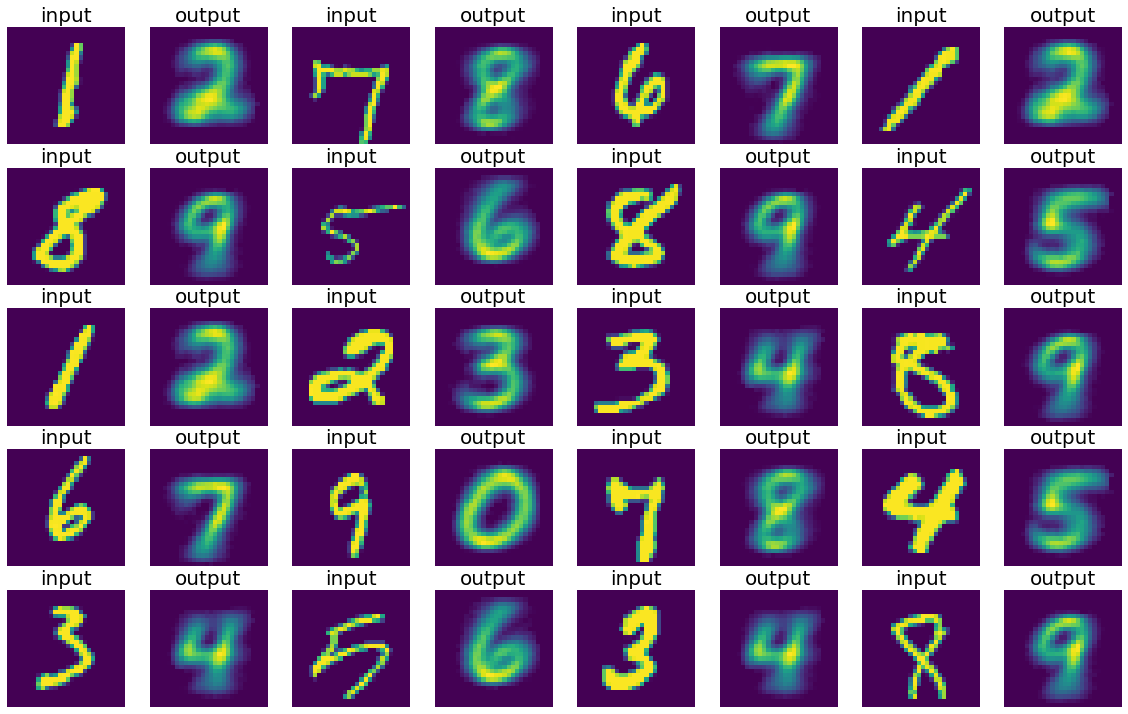

You should use the MNIST dataset, and the ground-truth for each example is provided by a helper function. Make sure to put the `ae_helper.py` file next to this notebook to use the helper function.

## Get the data

Get the data and split them into training, validation, and test sets, by running the following cell. `X` is the input images, `Y` is the ground-truth for each input, and `y` is the input's label.

In [2]:
from ae_helper import get_data
from sklearn.model_selection import train_test_split

X, Y, y = get_data()

X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(X, Y, y, test_size=0.2, random_state=17)
X_train, X_val, Y_train, Y_val, y_train, y_val = train_test_split(X_train, Y_train, y_train, test_size=0.1, random_state=17)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## Design your model

Please Implement your autoencoder model below. You MUST implement your model using the `torch` package. The model should input a batch of images and output the generated images for the whole batch. Your model can be consist of fully connected layers (using linear layers), but using fully-convolutional models has extra points.

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1), # 16 x 14 x 14
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # 32 x 7 x 7
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=7) # 64 x 1 x 1
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7), # 32 x 7 x 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), # 16 x 14 x 14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1), # 1 x 28 x 28
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## The dataset class, and the dataloaders

The following cells implement the dataset class and create the data loaders for training and validation sets. Feel free to modify the batch size for each data loader.

In [4]:
from typing import Tuple
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MnistNextDigitDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X).unsqueeze(1)  # Adding channel dimension
        self.Y = torch.from_numpy(Y).unsqueeze(1)  # Adding channel dimension
        self.y = torch.from_numpy(y)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, ...]:
        return self.X[i], self.Y[i], self.y[i]


In [5]:
train_dataloader = DataLoader(
    MnistNextDigitDataset(X_train, Y_train, y_train),
    batch_size=512,
    shuffle=True
)
val_dataloader = DataLoader(
    MnistNextDigitDataset(X_val, Y_val, y_val),
    batch_size=1024,
    shuffle=False
)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train_autoencoder(model: nn.Module, optimizer: torch.optim.Optimizer, dataloader: DataLoader) -> float:
    model.train()
    epoch_loss = 0
    for X, Y, _ in dataloader:
        X, Y = X.to(device), Y.to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = F.mse_loss(outputs, Y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * X.size(0)

    epoch_loss /= len(dataloader.dataset)
    return epoch_loss

def eval_autoencoder(model: nn.Module, dataloader: DataLoader) -> float:
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for X, Y, _ in dataloader:
            X, Y = X.to(device), Y.to(device)

            outputs = model(X)
            loss = F.mse_loss(outputs, Y)

            epoch_loss += loss.item() * X.size(0)

    epoch_loss /= len(dataloader.dataset)
    return epoch_loss


## Instantiate the model and optimizer

Instantiate your model and optimizer in the following cell. Feel free to choose the optimizer and its configurations such as learning rate, decay, etc.

In [7]:
ae = AutoEncoder().to(device=device)

# You can choose any optimizer you prefer. Here, we'll use Adam optimizer with a learning rate of 0.001.
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)

## Train your autoencoder

Write your training/validation loop in the following cell for an arbitrary number of epochs (until convergence is detected). Make sure to use proper and readable logging containing training and validation metrics for each epoch. Select and store the state dictionary of the best epoch model according to the metrics.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/20], Train Loss: 0.0973, Validation Loss: 0.0698
Epoch [2/20], Train Loss: 0.0692, Validation Loss: 0.0683
Epoch [3/20], Train Loss: 0.0678, Validation Loss: 0.0667
Epoch [4/20], Train Loss: 0.0645, Validation Loss: 0.0622
Epoch [5/20], Train Loss: 0.0606, Validation Loss: 0.0595
Epoch [6/20], Train Loss: 0.0588, Validation Loss: 0.0583
Epoch [7/20], Train Loss: 0.0579, Validation Loss: 0.0576
Epoch [8/20], Train Loss: 0.0573, Validation Loss: 0.0571
Epoch [9/20], Train Loss: 0.0570, Validation Loss: 0.0568
Epoch [10/20], Train Loss: 0.0567, Validation Loss: 0.0566
Epoch [11/20], Train Loss: 0.0564, Validation Loss: 0.0564
Epoch [12/20], Train Loss: 0.0562, Validation Loss: 0.0562
Epoch [13/20], Train Loss: 0.0561, Validation Loss: 0.0561
Epoch [14/20], Train Loss: 0.0559, Validation Loss: 0.0560
Epoch [15/20], Train Loss: 0.0558, Validation Loss: 0.0558
Epoch [16/20], Train Loss: 0.0557, Validation Loss: 0.0557
Epoch [17/20], Train Loss: 0.0555, Validation Loss: 0.0556
Epoch 

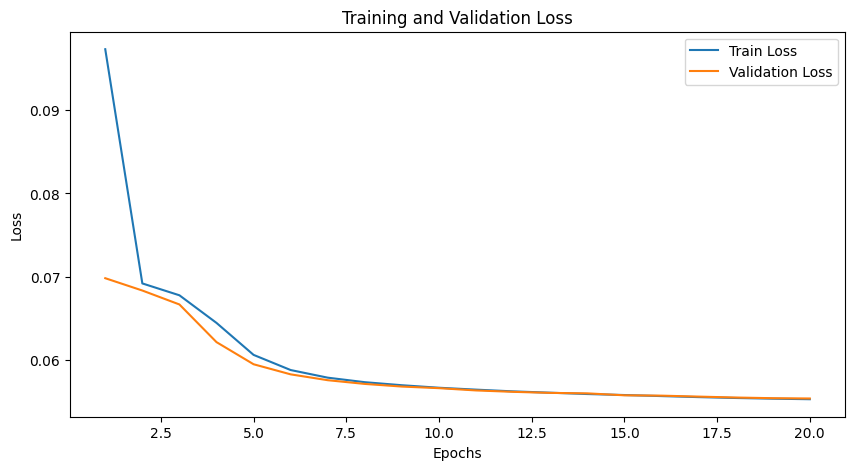

Best model saved to best_autoencoder_model with validation loss: 0.0554


In [8]:
#### TRAIN YOUR AUTOENCODER ####
import os
import torch
import matplotlib.pyplot as plt

num_epochs = 20  # You can set this to any number of epochs you prefer
best_val_loss = float('inf')
best_model_state = None

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = train_autoencoder(ae, optimizer, train_dataloader)
    val_loss = eval_autoencoder(ae, val_dataloader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = ae.state_dict()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Save the best model state
model_save_path = 'best_autoencoder_model'
torch.save(best_model_state, model_save_path)

# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

print(f"Best model saved to {model_save_path} with validation loss: {best_val_loss:.4f}")


## Load the state dictionary of the best epoch

Load the state dictionary of the best epoch model into the model object.

In [9]:
# Instantiate the model
best_ae = AutoEncoder().to(device)

# Load the best model state dictionary
best_ae.load_state_dict(torch.load('best_autoencoder_model'))

# Set the model to evaluation mode
best_ae.eval()

print("Best epoch model loaded successfully.")

Best epoch model loaded successfully.


## Visualize your model

Select 40 examples from the test set and visualize the input and output of the model for them (See the examples at the beginning of the notebook).

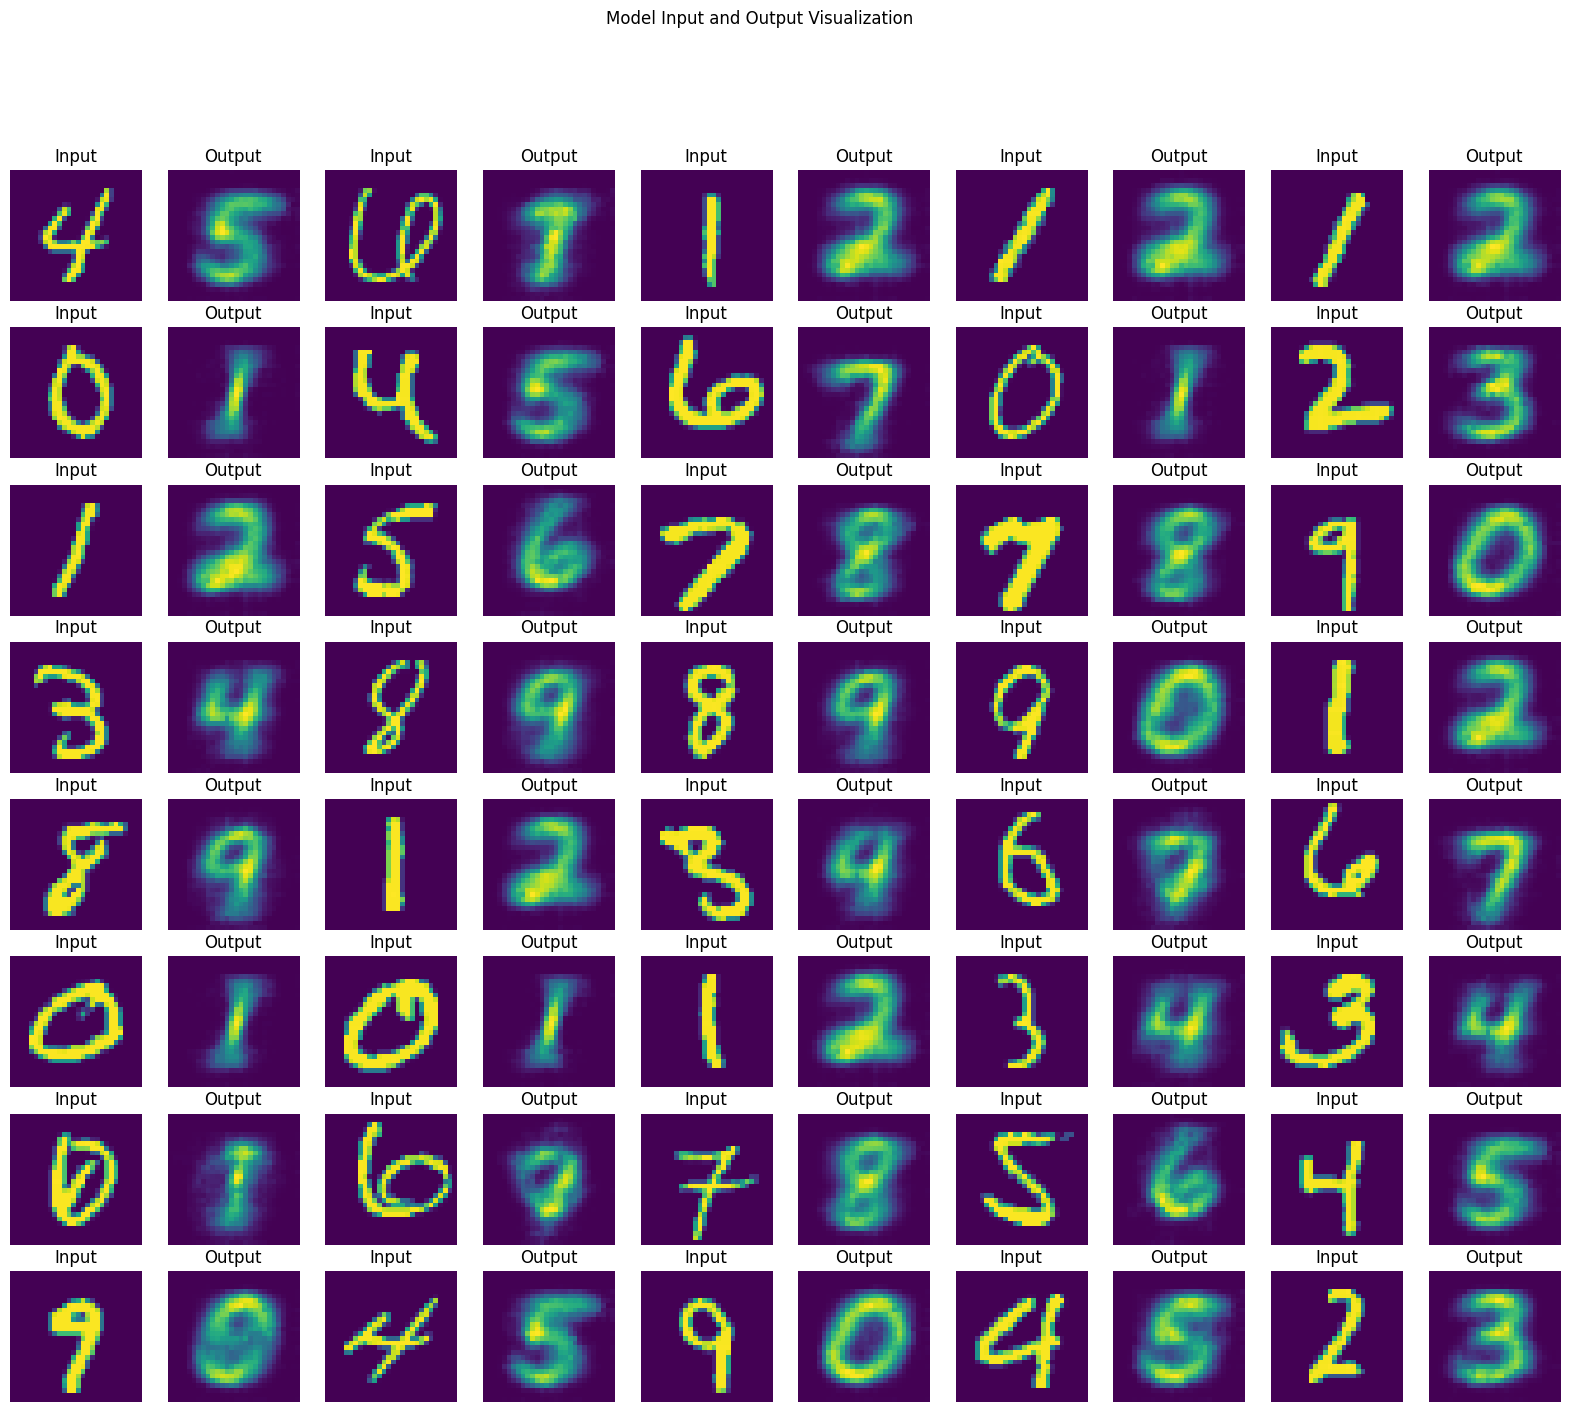

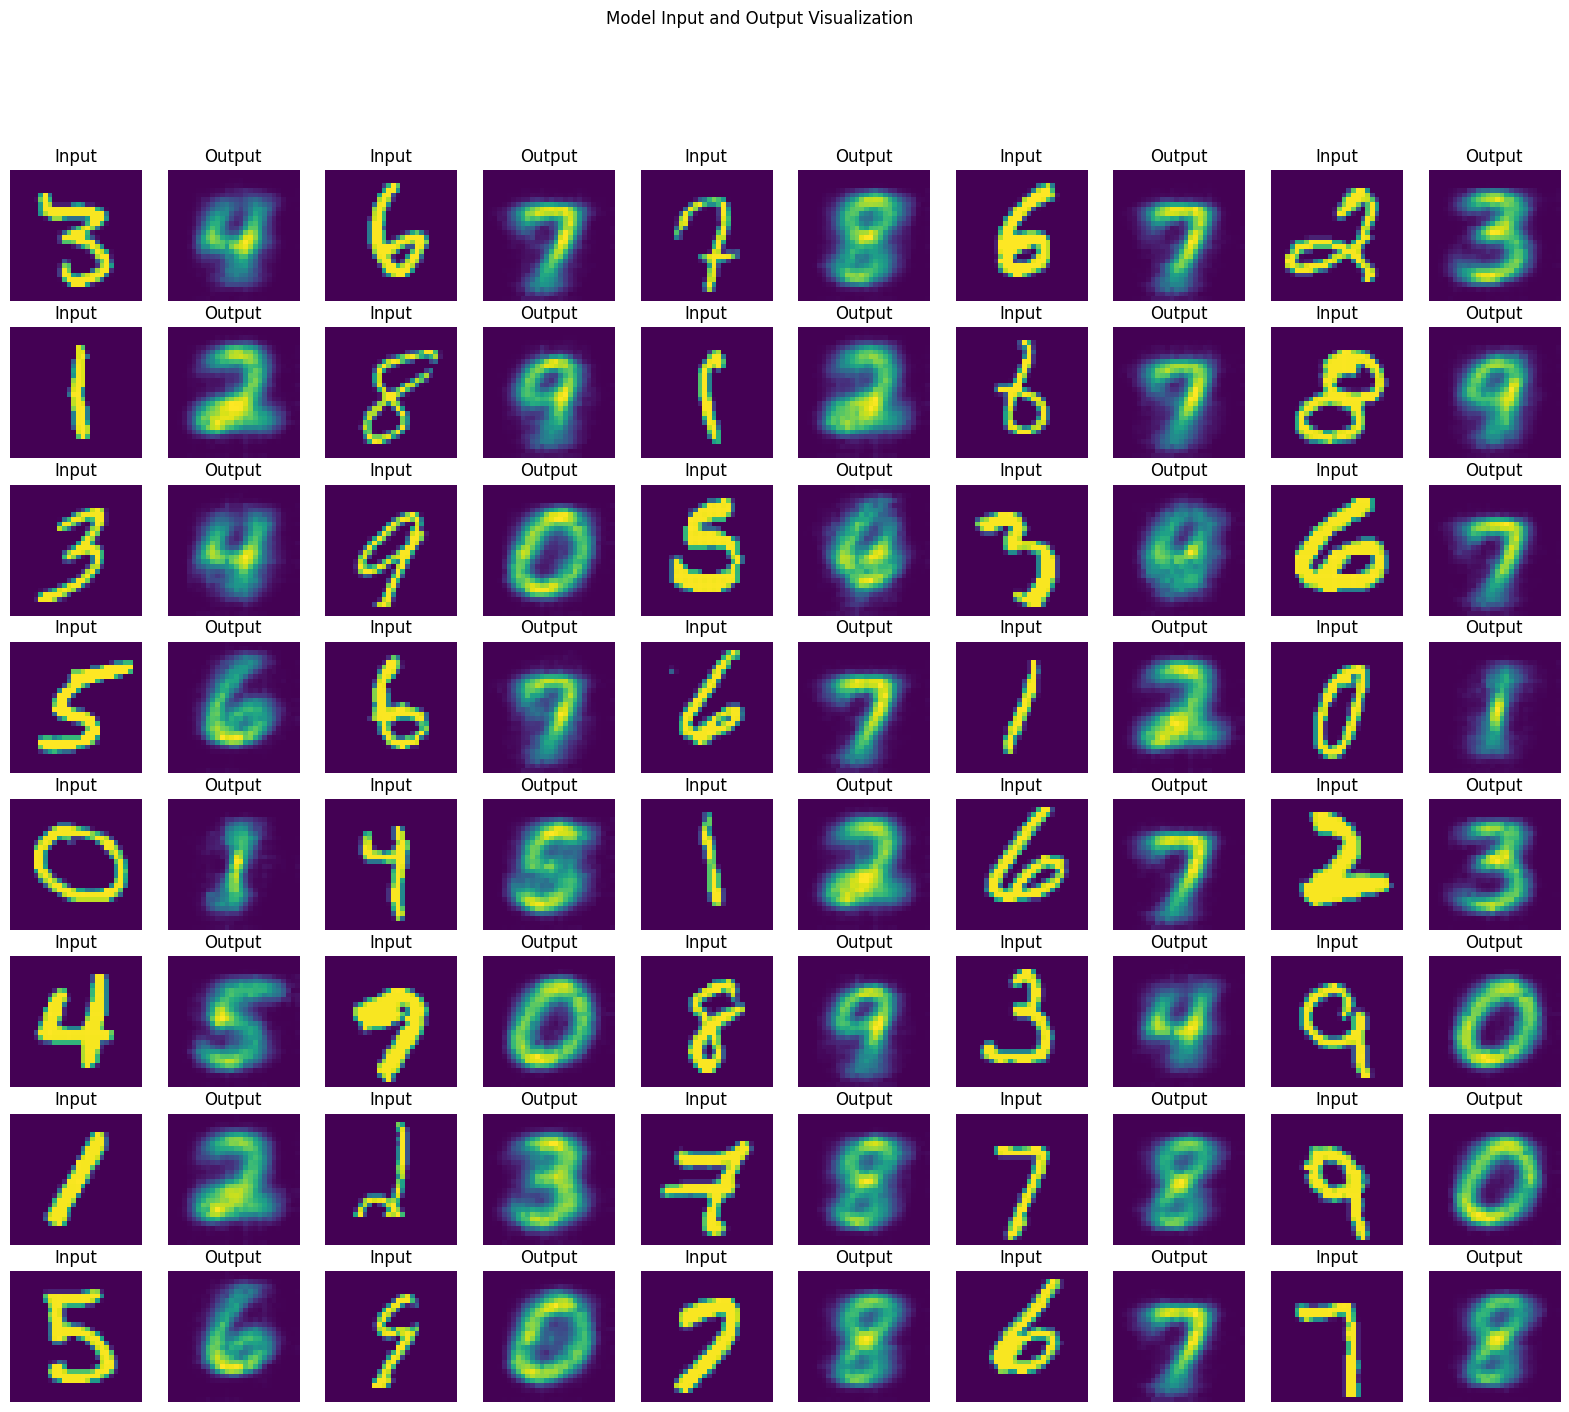

In [13]:
# Select 40 examples from the test set
num_examples = 40
examples_indices = np.random.choice(len(X_test), num_examples, replace=False)
X_test_selected = torch.from_numpy(X_test[examples_indices]).unsqueeze(1).to(device)  # Adding channel dimension

# Get the model's outputs for the selected examples
with torch.no_grad():
    outputs = best_ae(X_test_selected)

# Plot the input and output images
fig, axes = plt.subplots(nrows=8, ncols=10, figsize=(20, 16))

for i in range(num_examples):
    # Plot the input images
    ax = axes[i // 5, (i % 5) * 2]
    ax.imshow(X_test_selected[i].cpu().squeeze())
    ax.set_title("Input")
    ax.axis('off')

    # Plot the output images
    ax = axes[i // 5, (i % 5) * 2 + 1]
    ax.imshow(outputs[i].cpu().squeeze())
    ax.set_title("Output")
    ax.axis('off')

plt.suptitle('Model Input and Output Visualization')
plt.show()